# Simulate acoustic wave propagation of a planar piston source

The OptimUS library provides functionality to simulate acoustic wave propagation from a range of acoustic sources. This notebook demonstrates a simulation with a circular planar piston rigidly vibrating in an infinite baffle. Acoustic intensity and power calculations are carried out. Output quantities are compared with known analytical solutions. The piston velocity is scaled to produce the required acoustic power and the model is solved in the presence of a spherical scatterer.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## Specify a circular planar piston as acoustic source

The OptimUS library provides different predefined wave fields, among which is a circular planar piston source radiating in 2*pi space. The piston requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity amplitude and its location, which is in this case at [0, 0, 0], all units are in the SI system. We initially set the velocity of the piston source to unity (1 m/s) and compute the radiated power. Then we will compare this value with a desired acoustic power, let's say 0.1 W to estimate the source velocity needed to generate this desired acoustic power.

In [3]:
frequency = 1e6
piston_radius = 0.01
location = (0, 0, 0)
velocity = 1.0
source = optimus.source.create_piston(frequency, radius=piston_radius, location=location, source_axis=(1, 0, 0),
                                      velocity=velocity, number_of_point_sources_per_wavelength=24)

## Specify the physical settings for the simulation

Let us consider acoustic waves are propagating in an unbounded region of non-attenuating water.

In [4]:
material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                density=1000,
                                                speed_of_sound=1500)

In [5]:
material_ext.print()

                 name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water-no-attenuation   1000.0          1500.0                  0.0                0.0


## Calculating the wavelength in the exterior medium

In [6]:
import numpy as np
k = material_ext.compute_wavenumber(frequency)
lambd = np.real(2 * np.pi / np.abs(k))

## Obtain coordinates of points in a line parallel to the surface of the piston source, i.e. the $z$ axis, and in the farfield, e.g. passing through $x$ = 10 mm

This is for obtaining the acoustic power.

In [7]:
x_offset = 10.0e-3
y_offset = 0.0
zmin = 0.0
zmax = 15 * piston_radius
nz = int(zmax / lambd * 24)  # 24 points per wavelength
x_field = x_offset * np.ones(nz)
y_field = y_offset * np.ones(nz)
z_field = np.linspace(zmin, zmax, nz)
points = np.array((np.row_stack((x_field, y_field, z_field))))

## Generate unit normals at points on integration line

In [8]:
normals = np.zeros((3, points.shape[1]), dtype=float)
normals[0, :] = np.ones(points.shape[1], dtype=float)

## Calculate the incident field on a disc whose radius is 15 times the piston radius

Retrieve the incident pressure and calculate the particle velocity in along the $x$ direction. Calculate the $x$ component of the acoustic intensity.

In [9]:
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, normals=normals, verbose=True)
p_inc = inc_field.pressure
u_inc = inc_field.normal_pressure_gradient / (1j * 2 * np.pi * frequency * material_ext.density)
Ix = np.real(0.25 * (p_inc * np.conj(u_inc) + np.conj(p_inc) * u_inc))

Number of point sources across element diameter: 320
Number of point sources in transducer: 79900
Parallelisation method: multiprocessing
Parallelisation of incident field calculation over source locations


## Plot the acoustic intensity along the radius of the disc over which the field is to be integrated

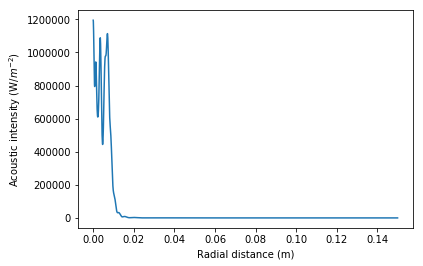

In [10]:
from matplotlib import pylab as plt
%matplotlib inline
plt.plot(points[2], Ix)
plt.xlabel('Radial distance (m)')
plt.ylabel('Acoustic intensity (W/$m^{-2}$)')
plt.show()

## Calculate acoustic power per unit velocity

Say we require an acoustic power of 0.1 W. Let us calculate the piston velocity to produce this output power.

In [11]:
power_at_unit_velocity = 2 * np.pi * np.sum(Ix * points[2]) * points[2, 1]

# Required acoustic power
power_desired = 0.1

# Calculate velocity to produce required power
piston_velocity = np.sqrt(power_desired / power_at_unit_velocity)
print('The required piston velocity to generate ', power_desired ,
      'W of acoustic power is:\n',power_at_unit_velocity, 'm/s')

The required piston velocity to generate  0.1 W of acoustic power is:
 235.03395997356037 m/s


## Check that the calculated piston velocity is in agreement with the analytical solution

http://www.silcom.com/~aludwig/Physics/Exact_piston/Exact_piston.htm

In [12]:
import scipy as sp
piston_velocity_check = np.sqrt( 2 * power_desired / 
                                (np.pi * piston_radius ** 2 * material_ext.density * material_ext.speed_of_sound
                                * (1 - 2 * sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius))))
print('Estimated velocity to produce ', power_desired, 
      ' W of acoustic power: ', np.real(piston_velocity_check), 'm/s')
print('Analytical value of velocity which produces ', power_desired, 
      ' W of acoustic power: ', piston_velocity, 'm/s')
print('Percentage difference with analytical solution: ', 
      100 * np.linalg.norm((piston_velocity_check - piston_velocity) / piston_velocity),
      '%')

Estimated velocity to produce  0.1  W of acoustic power:  0.0206220534984332 m/s
Analytical value of velocity which produces  0.1  W of acoustic power:  0.020626934574436383 m/s
Percentage difference with analytical solution:  0.023663603457752293 %


## Check that the power is in agreement with the analytical solution

In [13]:
bessel_func_term = sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius)
power_check = 0.5 * piston_velocity ** 2 * np.pi * piston_radius ** 2 * material_ext.density * \
              material_ext.speed_of_sound * (1 - 2 * bessel_func_term)
print('Required acoustic power: ', power_desired, ' W')
print('Analytical value of power produced by estimated velocity:', power_check, ' W')
print('Percentage difference with analytical solution: ', 
      100 * np.linalg.norm((power_check - power_desired) / power_desired), 
      '%')

Required acoustic power:  0.1  W
Analytical value of power produced by estimated velocity: (0.10004734401120127+4.051170692198562e-21j)  W
Percentage difference with analytical solution:  0.047344011201266856 %


## Assign velocity to piston source to produce required power and visualise the field

In [14]:
source.velocity = piston_velocity

## Visualisation of the acoustic field

Let us visualise the total pressure field on a grid in the plane $z$=0. To do so, we need to create the visualisation grid first using `optimus.utils.mesh.create_grid_points` function. This function takes the no. of points along axes of a 2D plane (here $x$ and $y$ axes), the limits of the plane along each axis, the axes of the plane and the output mode (numpy: to return ndarray, gmsh: to return gmsh grid).

In [15]:
grid_resolution = (101,101)
grid_lims = (0.005, 0.12, -2 * piston_radius, 2 * piston_radius)
points_vis = optimus.utils.mesh.create_grid_points(resolution=grid_resolution,
                                                   plane_axes=(0,1),
                                                   plane_offset=0,
                                                   bounding_box=grid_lims,
                                                   mode="numpy")

In [ ]:
inc_field_desired = transducer_field(source, material_ext, points_vis[0], verbose=True)

Number of point sources across element diameter: 320
Number of point sources in transducer: 79900
Parallelisation method: multiprocessing
Parallelisation of incident field calculation over source locations


In [ ]:
p_inc_plt = np.abs(inc_field_desired.pressure.reshape(grid_resolution)).T/1E3
fig = optimus.postprocess.plot.surface_plot(p_inc_plt,
                                      axes_lims=grid_lims,
                                      axes_labels=["x [m]","y [m]"],
                                      colormap="viridis",
                                      colormap_lims=[0,np.max(abs(p_inc_plt))],
                                      colorbar_unit="$P_{inc}$ [kPa]",
                                      domains_edges=None)